In [1]:
import pandas as pd
import numpy as np
import os
import re

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir('/shared/0/projects/research-jam-summer-2024/')

In [3]:
base_dir = 'data/english_only/prompting_results_clean/with_metrics/' #experiment 1
#base_dir = 'data/english_only/100k_results/with_metrics' #experiment 2

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def radar_plot(categories, datasets, errors=None, title="Awesome Metrics"):
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True))

    # Color palette - vibrant colors with good contrast
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

    # Calculate the offset angle
    offset_angle = 2 * pi / (N * 20)  # Adjust this value to increase/decrease offset


    # Plot each dataset
    for i, (label, values) in enumerate(datasets.items()):
        values += values[:1]  # Repeat the first value to close the polygon
        
        # Calculate offset angles for this dataset
        dataset_angles = [angle + (i - len(datasets) / 2 + 0.5) * offset_angle for angle in angles]
        
        ax.plot(dataset_angles, values, 'o-', linewidth=3, color=colors[i % len(colors)], label=label)
        
        ax.fill(dataset_angles, values, alpha=0.08, color=colors[i % len(colors)])

        # Add error bars if provided
        if errors and label in errors:
            err = errors[label] + errors[label][:1]
            for j in range(len(values)):
                ax.errorbar(dataset_angles[j], values[j], yerr=err[j], fmt='none', 
                            ecolor=colors[i % len(colors)], capsize=6, capthick=4, elinewidth=3.5, alpha=0.8)

    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=14, fontweight='bold')

    # Set y-axis labels
    ax.set_rlabel_position(0)
    ax.set_rticks([0.2, 0.4, 0.6])
    y_labels = ax.set_yticklabels(["0.2", "0.4", "0.6"], color="#333333", fontsize=15)
    ax.set_ylim(0, 0.7)

    # Add subtle gridlines with increased opacity and thickness
    ax.grid(color='#C0C0C0', linestyle='--', linewidth=1, alpha=1)

    # Remove spines
    ax.spines['polar'].set_visible(False)

    # Add a legend with a semi-transparent background
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0), fontsize=14)
    legend.get_frame().set_alpha(0.0)
    legend.get_frame().set_facecolor('#F0F0F0')

    # Set background color for the plot area
    ax.set_facecolor('#F7FBFF')  # Very light blue color

    # Add title with adjusted position
    plt.title(title, fontsize=22, fontweight='bold', pad=30, color='#333333')

    # Adjust layout and display
    plt.tight_layout()

    return fig, ax



In [4]:
metrics = pd.read_json('data/wildchat_subset_en_2k_prompting_all_normalized_metrics.jsonl', 
                       orient='records', lines=True)

In [228]:
import json

contractions_dict = json.load(open('data/contractions_dict.json','r'))
def get_contract_count(text):
    return np.mean([1 if word in contractions_dict or word.lower() in contractions_dict else 0 
                    for word in text.split()])


metrics['human_contract_count'] = metrics.human_turn_3.apply(get_contract_count)
metrics['llm_contract_count'] = metrics.llm_turn_3.apply(get_contract_count)
metrics['metric_contract_count'] = 1 - np.abs(metrics['llm_contract_count'] - metrics['human_contract_count'])

In [102]:
cot_prompts = [5,9,10,12,17,19,25,26,28,30,31,33,46]
weird_prompts = [28,33,35,37,38,40,41,42,43,45,47,50]
override_prompts = [11,22,29,48,49]
override_prompts.extend(weird_prompts)
human_prompts = [i for i in range(1,51) 
                 if i not in cot_prompts and i not in weird_prompts and i not in override_prompts]
metrics['prompt_type'] = metrics.prompt.apply(lambda x: 'COT' if int(x[7:]) in cot_prompts
                                                else 'Override' if int(x[7:]) in override_prompts
                                                else 'Human' if int(x[7:]) in human_prompts
                                                else 'Other'
                                                )

In [103]:
metrics['model'] = metrics['model'].apply(lambda x: re.sub('wildchat_subset_en_2k_prompting_|.jsonl','',x))


In [93]:
from copy import deepcopy 
'metric_end'

lexical = ['metric_log_word_count',
           'metric_log_word_length',
           'metric_perplexity',
           'metric_typo',
          ]

orthographic = ['metric_capitalization',
                'metric_punctuation',
                'metric_contract_count',
                'metric_elongation',
               ]

syntactic = [#'metric_grammar',
             'metric_pos',
             #'metric_constituency_parse',
            ]

semantic = ['metric_sbert',
            'metric_rouge',
            #'metric_bleu',
            'metric_liwc',
            'metric_topic',
           ]

style = ['metric_sentiment',
         'metric_politeness',
         'metric_formality',
         'metric_toxicity',
         'metric_factuality',
         'metric_readability',
         'metric_subjectivity',
         'metric_luar',
        ]


all_metrics = deepcopy(lexical)
all_metrics.extend(orthographic)
all_metrics.extend(syntactic)
all_metrics.extend(semantic)
all_metrics.extend(style)

<Axes: >

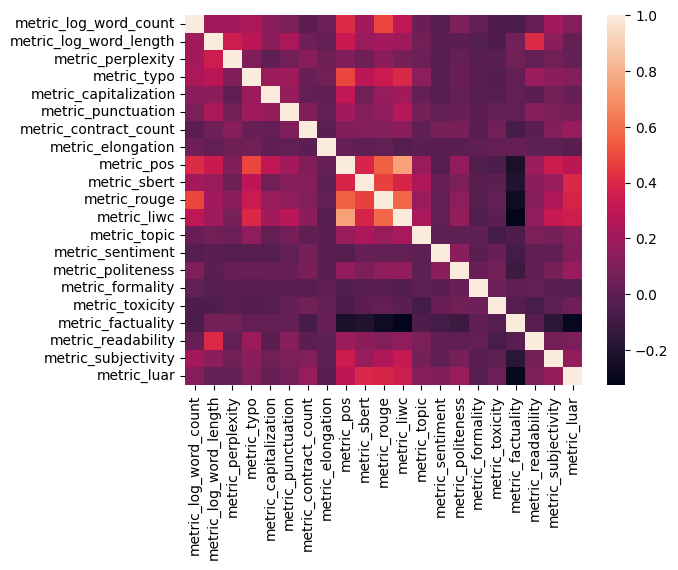

In [95]:
sns.heatmap(metrics[all_metrics].corr())

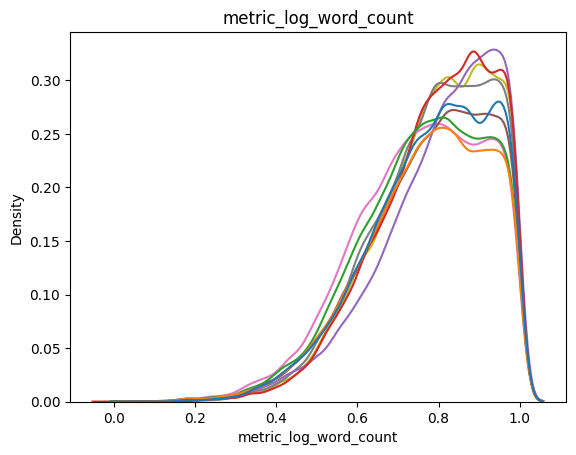

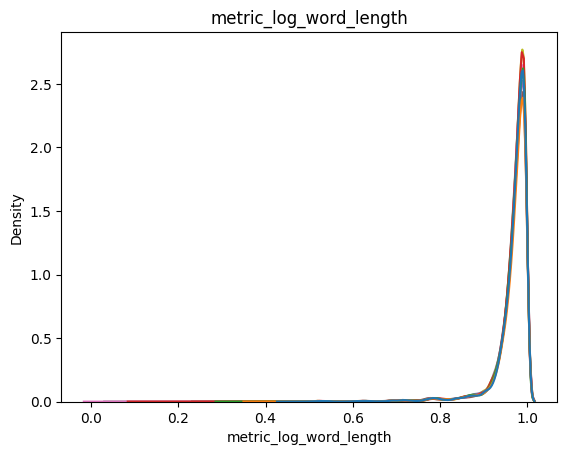

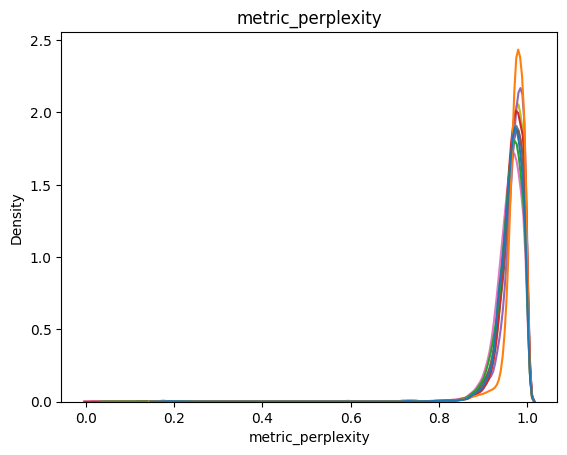

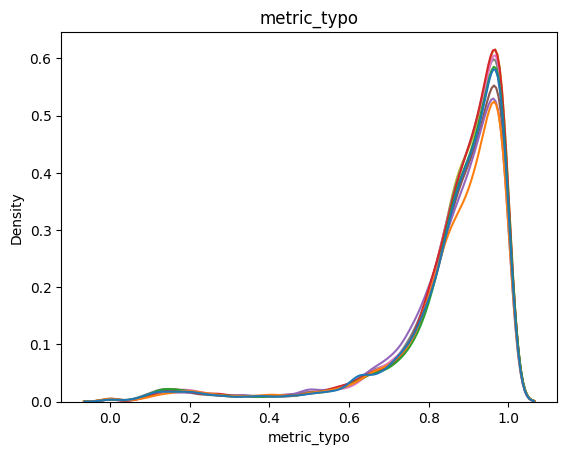

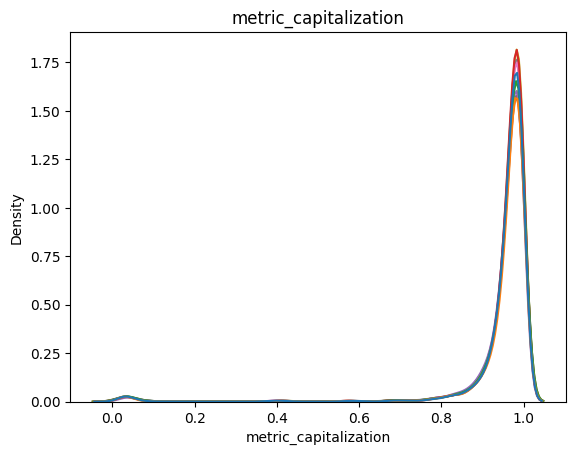

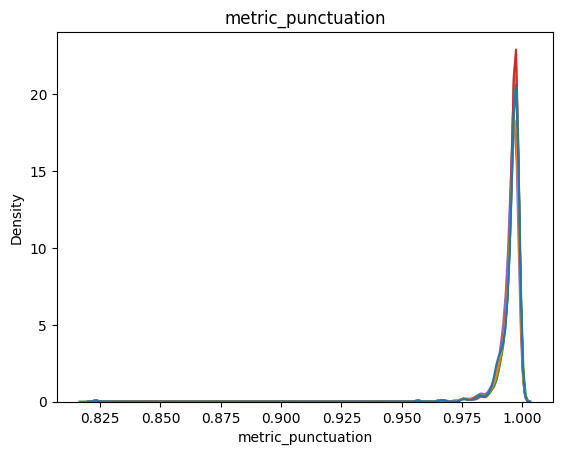

/tmp/ipykernel_2800032/1534682415.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x = c, hue = 'model', data=metrics, legend=False)


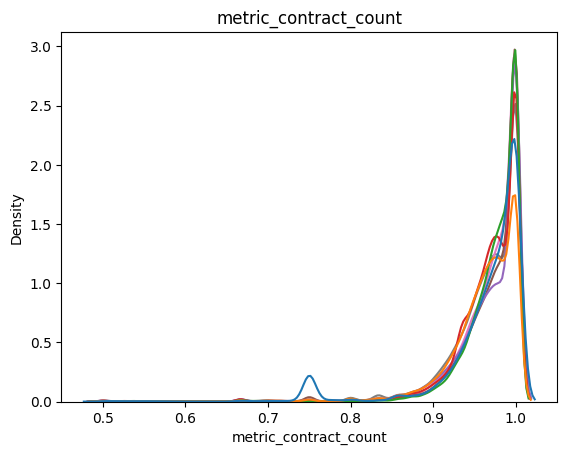

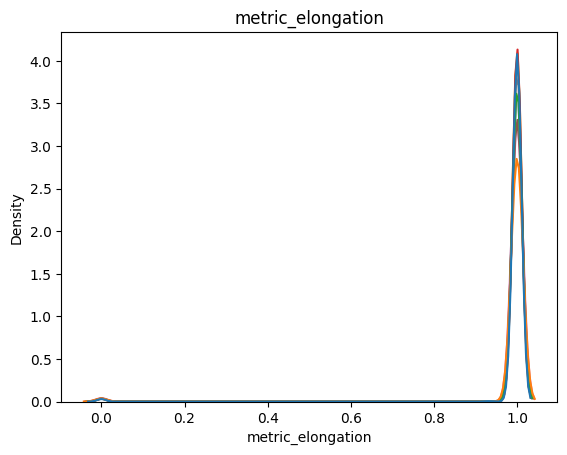

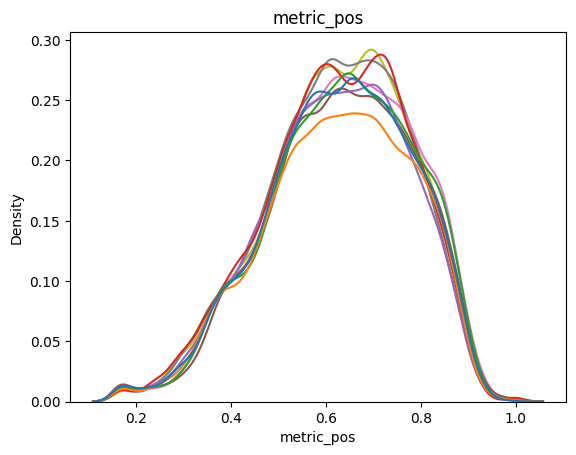

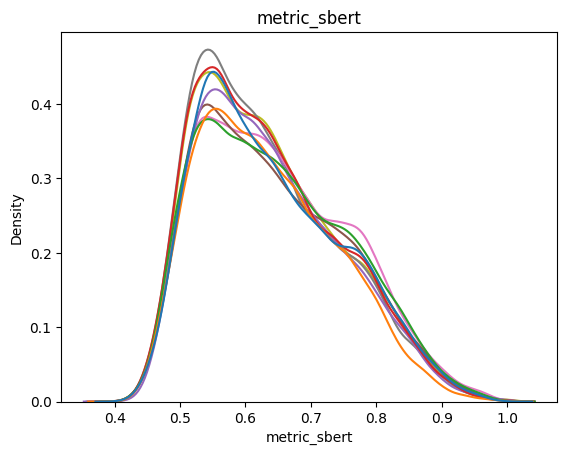

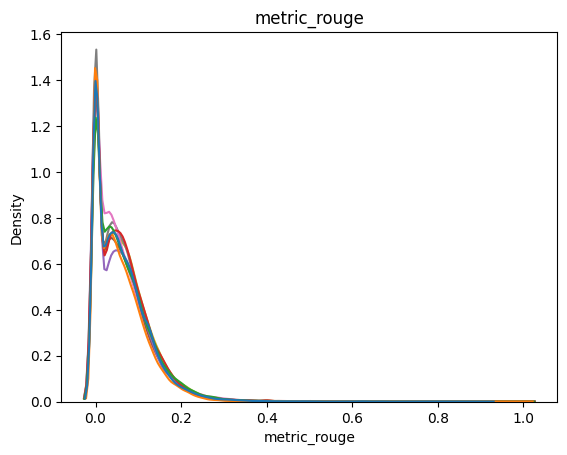

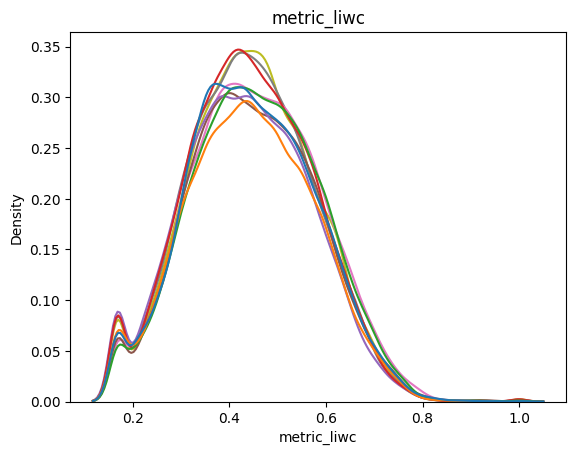

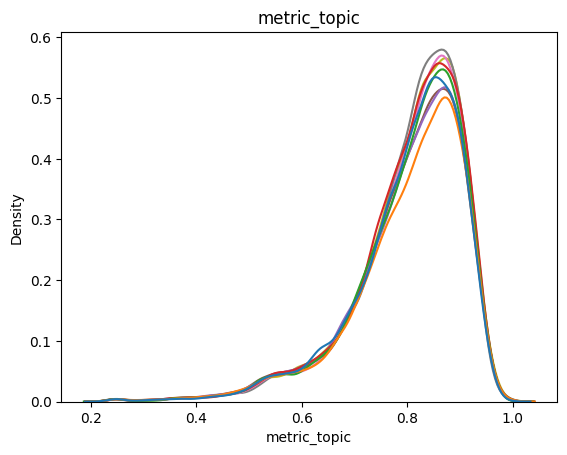

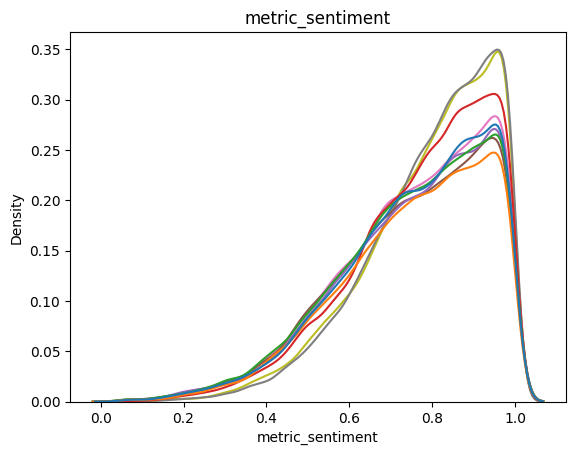

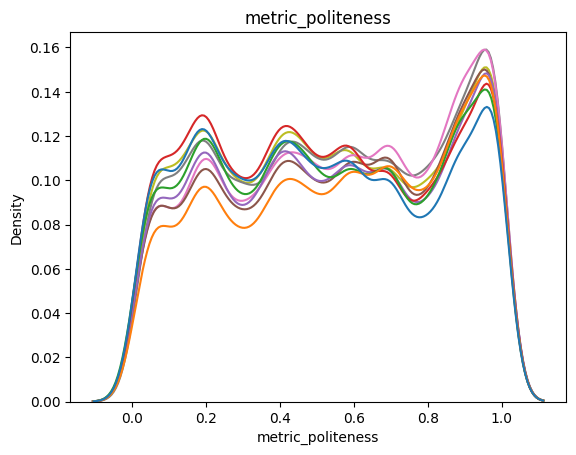

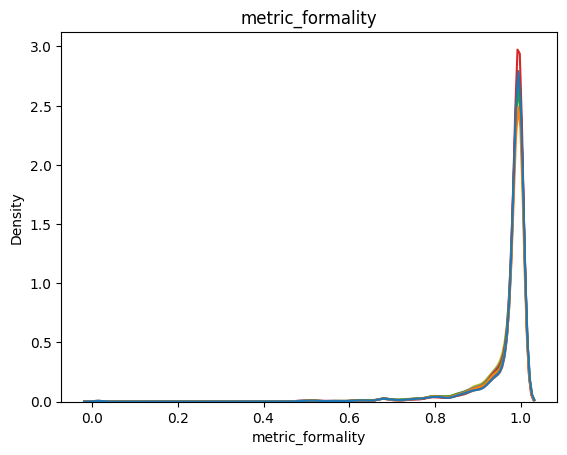

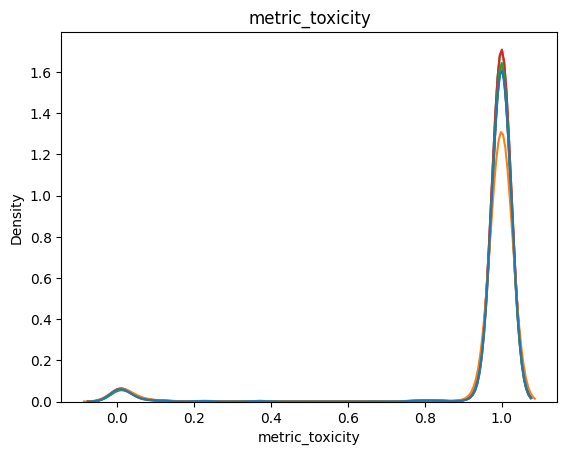

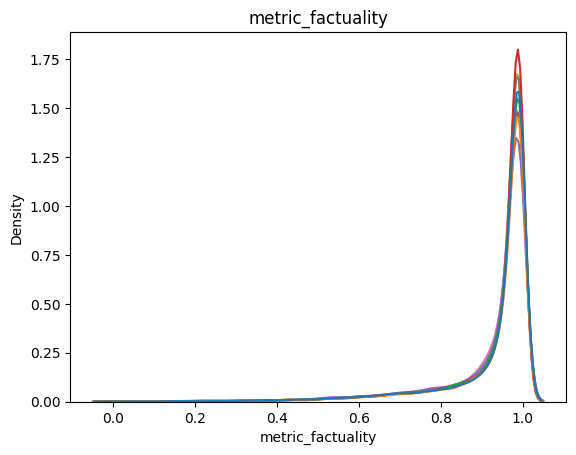

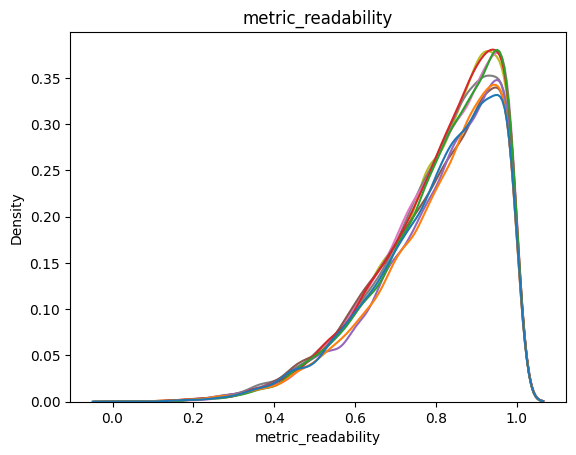

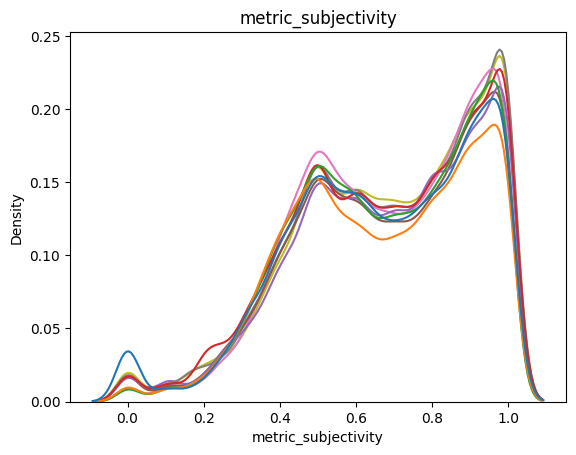

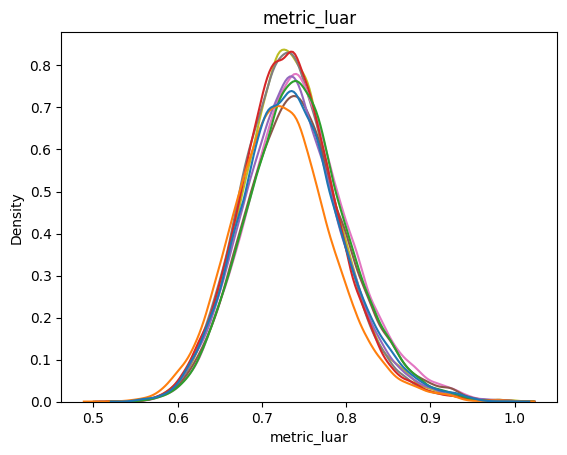

In [127]:
for c in all_metrics:
    sns.kdeplot(x = c, hue = 'model', data=metrics, legend=False)
    #sns.move_legend(g, "left", bbox_to_anchor=(1.5, 1.5))
    plt.title(c)
    plt.show()


In [264]:
def make_point_plots(plot_df2, diff_measure=''):
    ax = sns.pointplot(x = 'corr', y = 'metric', hue = 'model', linestyle = '',
                       data = plot_df2[plot_df2.metric.isin([re.sub('metric_','',c) for c in lexical])])
    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1.1), ncol=5, title=None, frameon=False,)
    plt.xlabel('similarity ('+diff_measure+')')
    plt.ylabel('')
    plt.xlim(0,1)
    plt.title('Lexical Similarity')
    plt.show()

    ax = sns.pointplot(x = 'corr', y = 'metric', hue = 'model', linestyle = '',
                       data = plot_df2[plot_df2.metric.isin([re.sub('metric_','',c) for c in orthographic])])
    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1.1), ncol=5, title=None, frameon=False,)
    plt.xlabel('similarity ('+diff_measure+')')
    plt.ylabel('')
    plt.xlim(0,1)
    plt.title('Orthographic Similarity')
    plt.show()

    ax = sns.pointplot(x = 'corr', y = 'metric', hue = 'model', linestyle = '',
                       data = plot_df2[plot_df2.metric.isin([re.sub('metric_','',c) for c in semantic])])
    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1.1), ncol=5, title=None, frameon=False,)
    plt.xlabel('similarity ('+diff_measure+')')
    plt.ylabel('')
    plt.xlim(0,1)
    plt.title('Semantic Similarity')
    plt.show()

    ax = sns.pointplot(x = 'corr', y = 'metric', hue = 'model', linestyle = '',
                       data = plot_df2[plot_df2.metric.isin([re.sub('metric_','',c) for c in style])])
    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1.1), ncol=5, title=None, frameon=False,)
    plt.xlabel('similarity ('+diff_measure+')')
    plt.ylabel('')
    plt.xlim(0,1)
    plt.title('Style Similarity')
    plt.show()

def remove_metric(l):
    return [re.sub('metric_','',c) for c in l] 


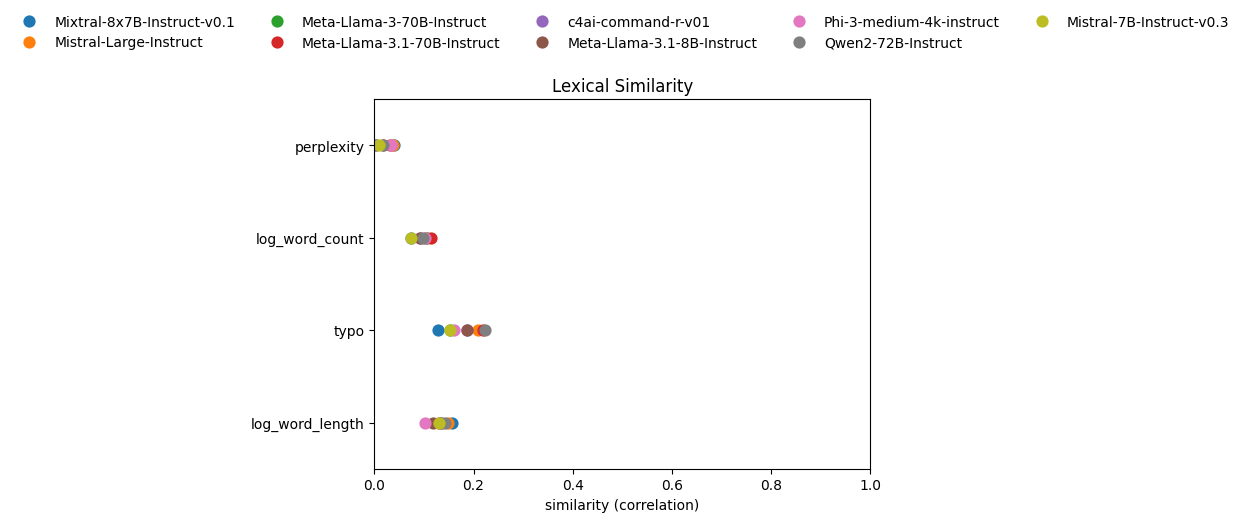

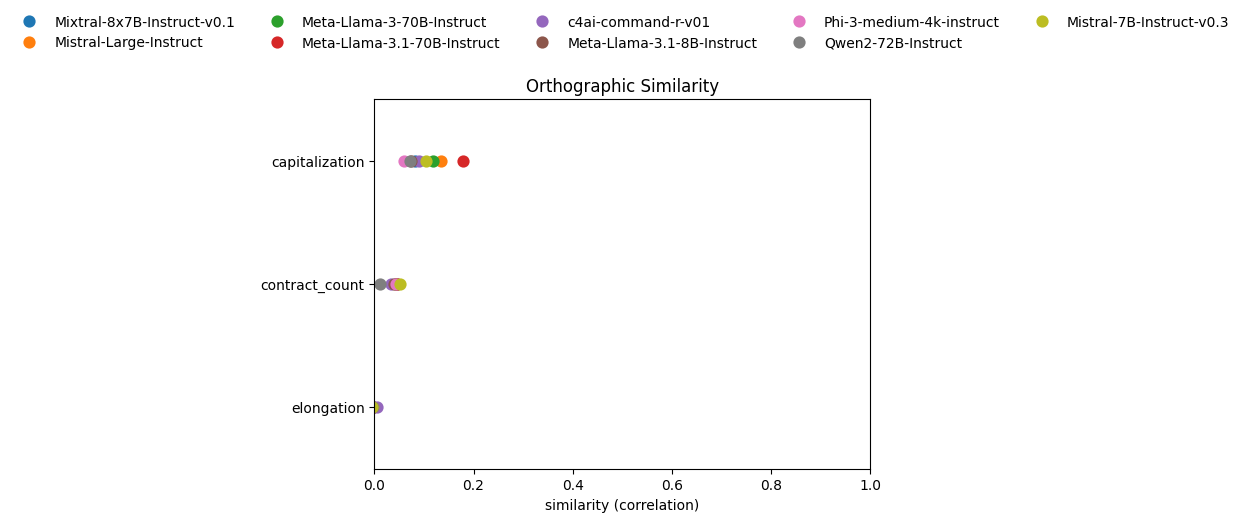

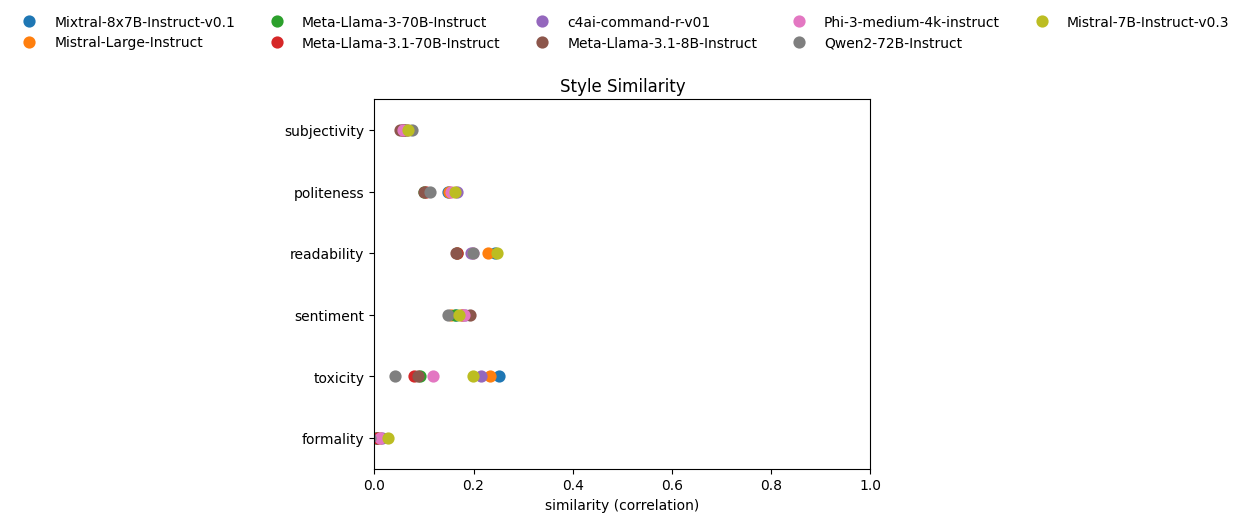

In [263]:
var = 'model'
model = []
metric = []
corr = []
for mod in set(metrics[var]):
    cond = metrics[var] == mod
    for m in [re.sub('human_','',c) for c in metrics.columns 
              if c.startswith('human_') and not c in ['human_end','human_word_count']]:
        if not 'turn' in m:
            if type(metrics['human_'+m][0]) != dict and type(metrics['human_'+m][0]) != list:
                model.append(mod)
                metric.append(m)
                corr.append(metrics[cond][['human_'+m,'llm_'+m]].corr()['human_'+m]['llm_'+m])
#             else:
#                 model.append(mod)
#                 metric.append(m)
#                 corr.append(np.mean(metrics[cond]['metric_'+m]))
                
#     for m in set([re.sub('metric_','',c) for c in all_metrics]) - set([re.sub('human_','',c) for c in metrics.columns if c.startswith('human_')]):
#             model.append(mod)
#             metric.append(m)
#             corr.append(np.mean(metrics[cond]['metric_'+m]))
        
    
plot_df = pd.DataFrame({'model':model, 'metric':metric, 'corr':corr})
plot_df['category'] = plot_df['metric'].apply(lambda x: 'lexical' if x in remove_metric(lexical)
                                            else 'orthographic' if x in remove_metric(orthographic)
                                            else 'syntactic' if x in remove_metric(syntactic)
                                            else 'semantic' if x in remove_metric(semantic)
                                            else 'style' if x in remove_metric(style) else 'other')
make_point_plots(plot_df,diff_measure='correlation')


In [267]:
np.mean(metrics.metric_sbert),np.mean(metrics.metric_luar)

(0.6387857943528822, 0.7370183343581003)

(<Figure size 1400x1000 with 1 Axes>,
 <PolarAxes: title={'center': 'Awesome Metrics'}>)

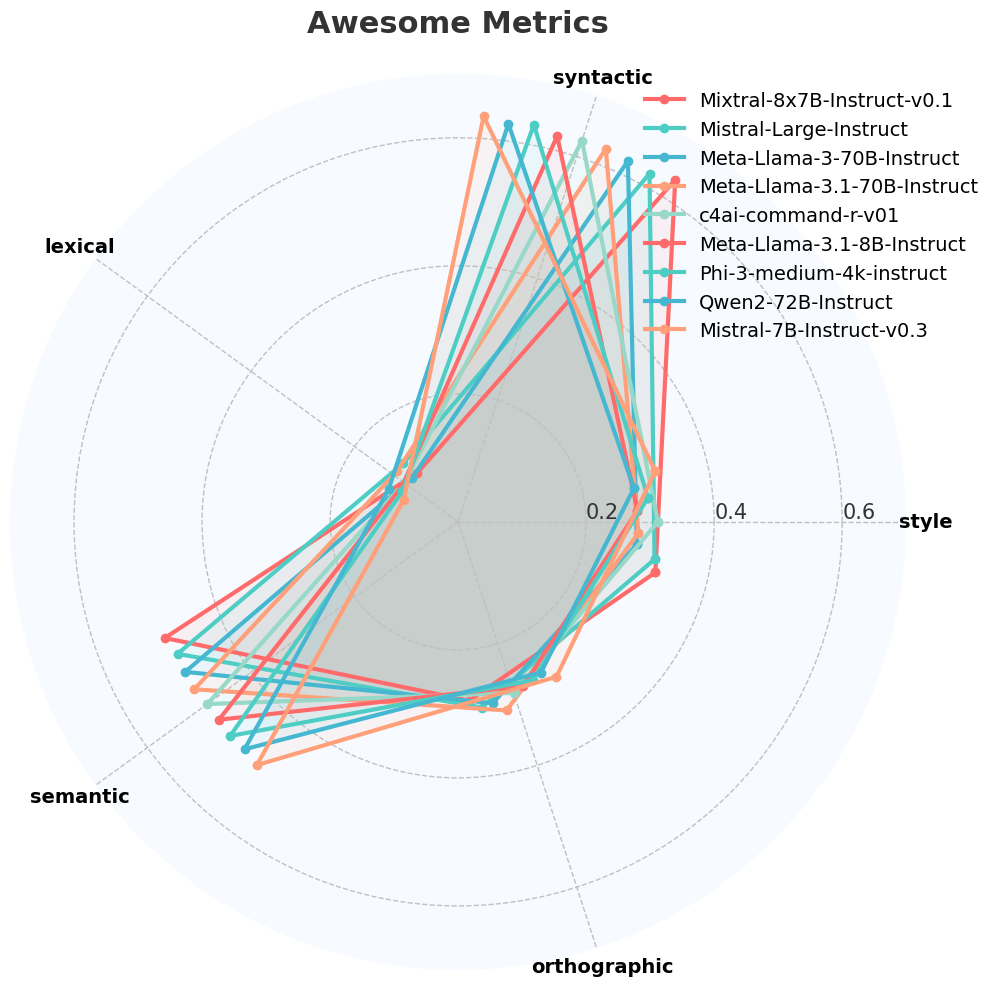

In [233]:
var = 'model'
radar_plot_df = plot_df[plot_df['category']!='other'].groupby([var,'category'])['corr'].mean().reset_index()
categories = list(set(radar_plot_df.category))
datasets = {m: [radar_plot_df[(radar_plot_df[var]==m) & (radar_plot_df['category']==c)]['corr'].tolist()[0]
                for c in categories] for m in set(metrics[var])}
radar_plot(categories, datasets)

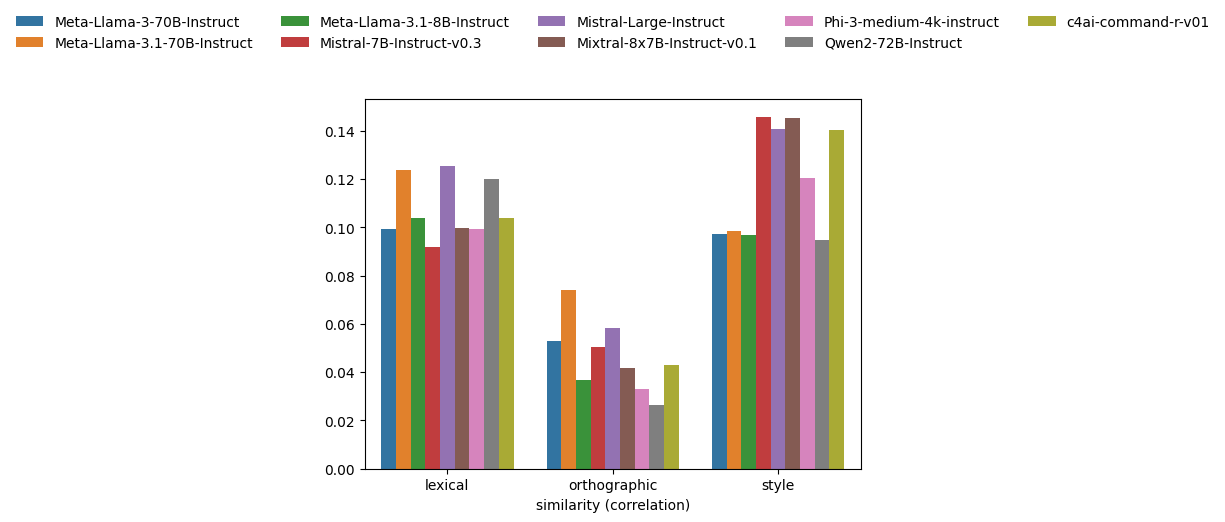

In [265]:
ax = sns.barplot(data = plot_df[plot_df.category!='other'].groupby(['model','category'])['corr'].mean().reset_index(),
                 x = 'category', y = 'corr', hue = 'model')
sns.move_legend(ax, "lower center",
                bbox_to_anchor=(.5, 1.1), ncol=5, title=None, frameon=False,)
plt.xlabel('similarity (correlation)')
plt.ylabel('')
plt.show()


In [266]:
plot_df.groupby(['category','metric'])['corr'].mean().res

category      metric         
lexical       log_word_count     0.095021
              log_word_length    0.133162
              perplexity         0.021506
              typo               0.179702
orthographic  capitalization     0.101189
              contract_count     0.039917
              elongation        -0.002282
other         word_length        0.141238
style         formality          0.006636
              politeness         0.133146
              readability        0.201250
              sentiment          0.170180
              subjectivity       0.062160
              toxicity           0.146600
Name: corr, dtype: float64

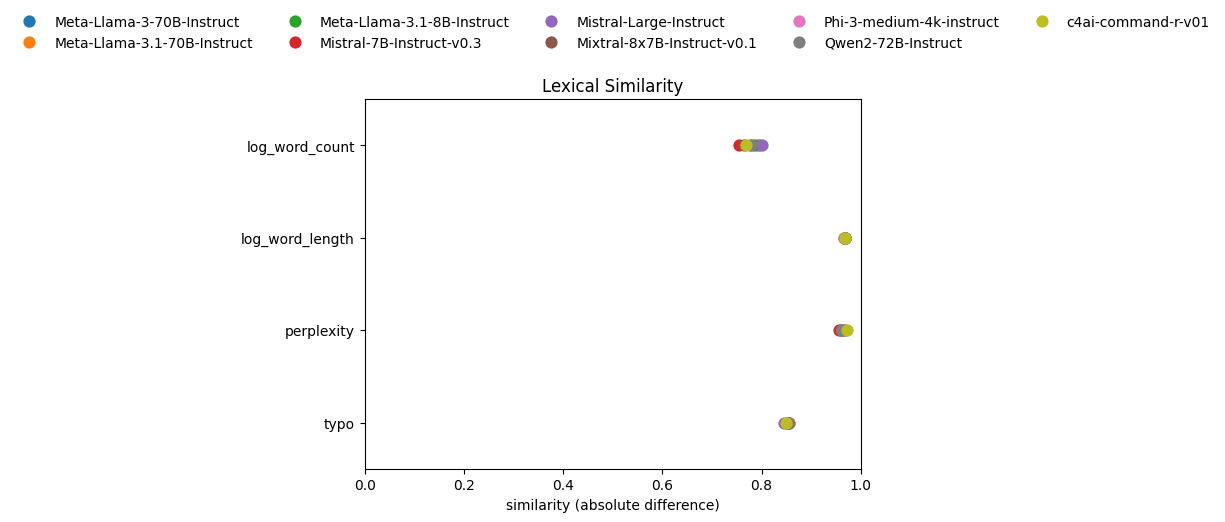

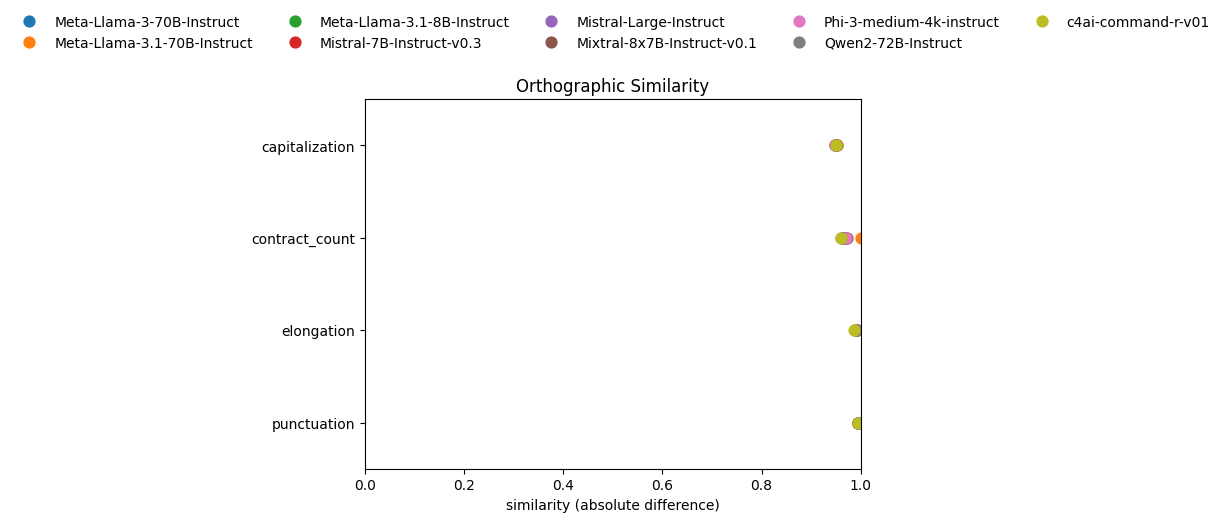

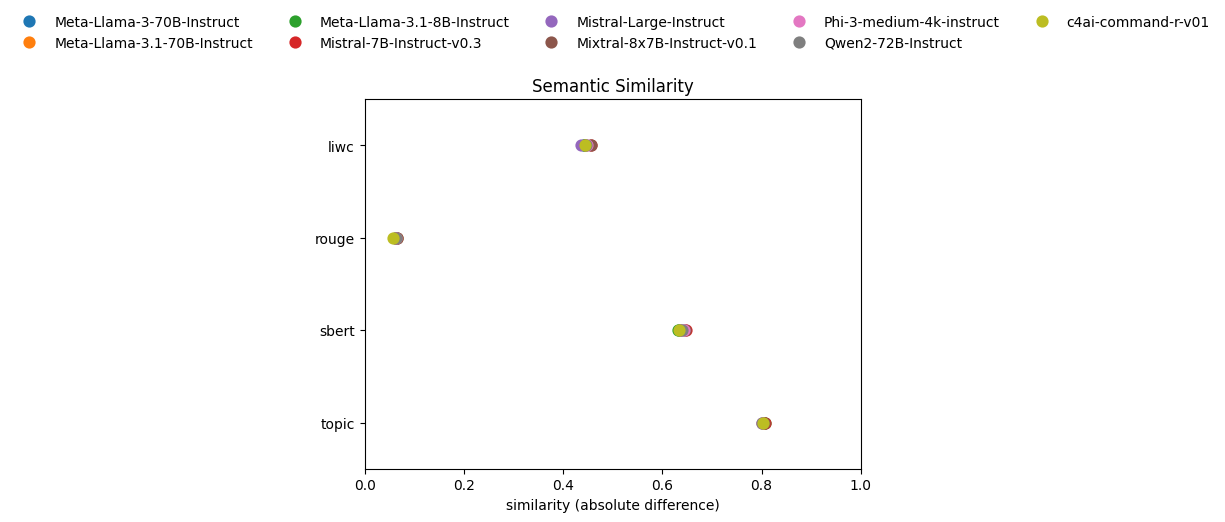

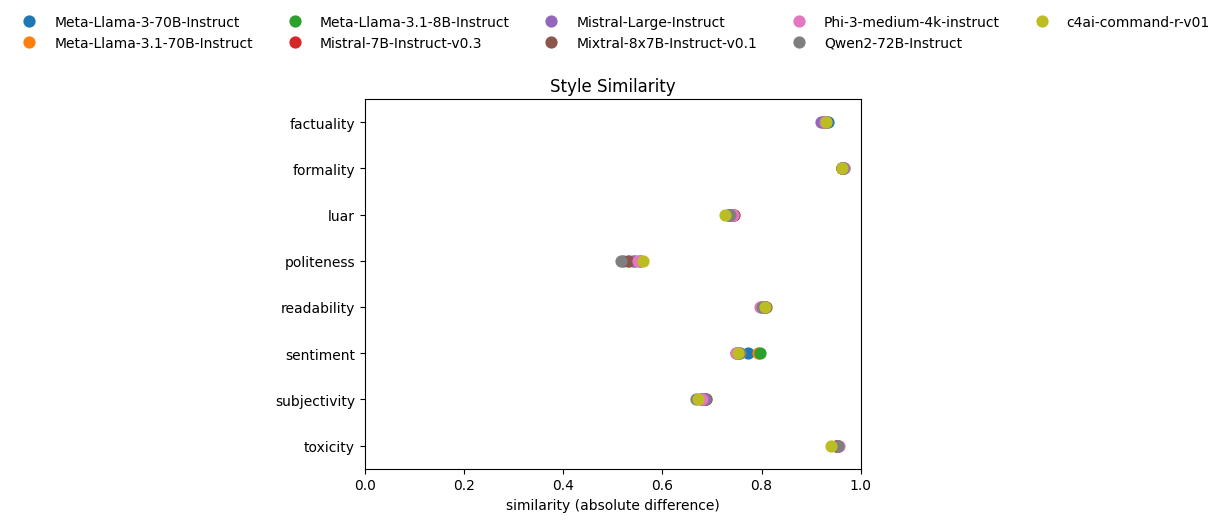

In [152]:
plot_df2 = pd.melt(metrics, id_vars=['conversation_hash','model','prompt'], 
                   value_vars=[c for c in metrics.columns if c.startswith('metric_') or c.startswith('agg_')],
                   var_name='metric', value_name='corr')
plot_df2['metric'] = plot_df2['metric'].apply(lambda c: re.sub('metric_','',c))
plot_df2 = plot_df2.groupby(['model','metric'])['corr'].mean().reset_index()
plot_df2['category'] = plot_df2['metric'].apply(lambda x: 'lexical' if x in remove_metric(lexical)
                                            else 'orthographic' if x in remove_metric(orthographic)
                                            else 'syntactic' if x in remove_metric(syntactic)
                                            else 'semantic' if x in remove_metric(semantic)
                                            else 'style' if x in remove_metric(style) else 'other')

make_point_plots(plot_df2, diff_measure='absolute difference')


(<Figure size 1400x1000 with 1 Axes>,
 <PolarAxes: title={'center': 'Awesome Metrics'}>)

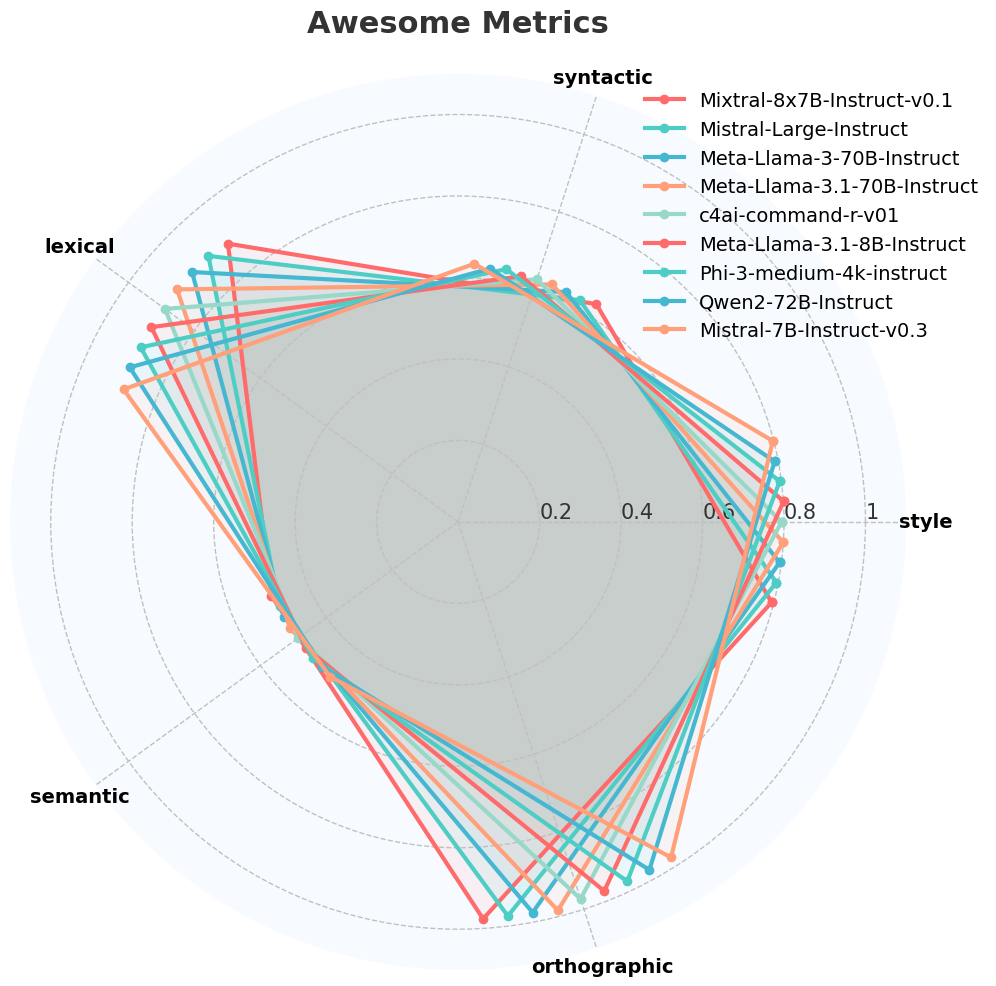

In [155]:
var = 'model'
radar_plot_df = plot_df2[plot_df2['category']!='other'].groupby([var,'category'])['corr'].mean().reset_index()
categories = list(set(radar_plot_df.category))
datasets = {m: [radar_plot_df[(radar_plot_df[var]==m) & (radar_plot_df['category']==c)]['corr'].tolist()[0]
                for c in categories] for m in set(metrics[var])}
radar_plot(categories, datasets)

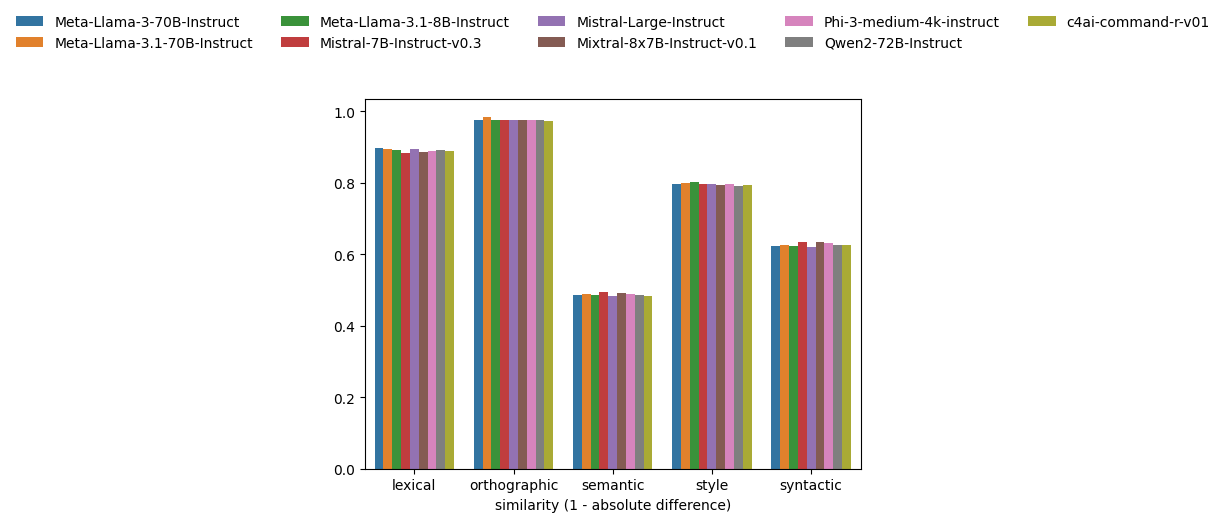

In [249]:
ax = sns.barplot(data = plot_df2[plot_df2.category!='other'].groupby(['model','category'])['corr'].mean().reset_index(),
                 x = 'category', y = 'corr', hue = 'model')
sns.move_legend(ax, "lower center",
                bbox_to_anchor=(.5, 1.1), ncol=5, title=None, frameon=False,)
plt.xlabel('similarity (1 - absolute difference)')
plt.ylabel('')
plt.show()


95    0.987757
Name: corr, dtype: float64

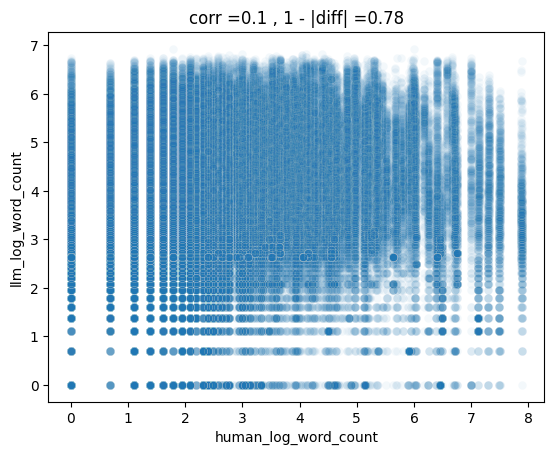

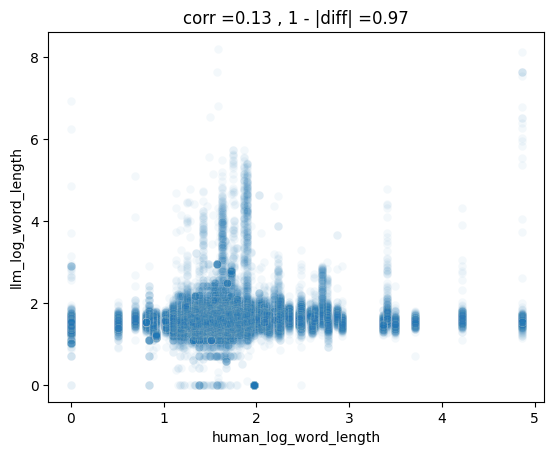

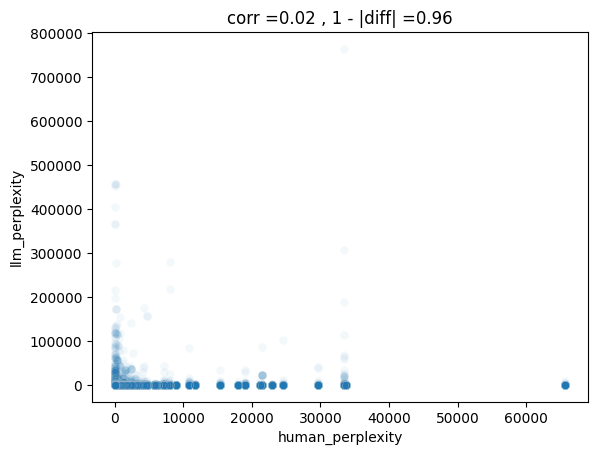

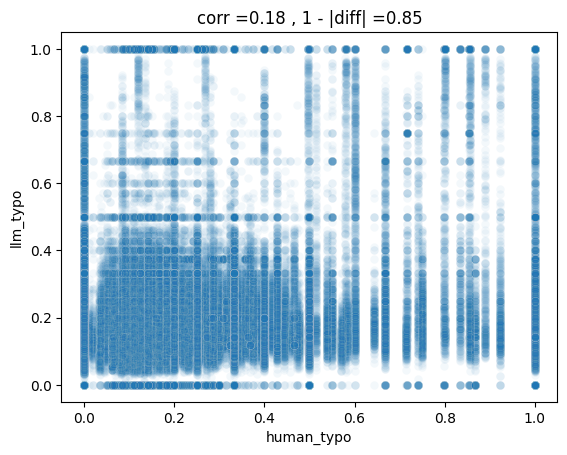

In [256]:
mod = 'Mistral-7B-Instruct-v0.3'
for c in [re.sub('metric_','',x) for x in lexical]:
    if 'human_'+c in metrics.columns:
        if type(metrics['human_'+c][0])!=dict and type(metrics['human_'+c][0])!=list:
            sns.scatterplot(data = metrics, x = 'human_'+re.sub('metric_','',c), y = 'llm_'+re.sub('metric_','',c), alpha = 0.05)
            plt.title('corr =' + str(round(np.mean(plot_df[(plot_df.metric==c)]['corr']),2)) + 
                      ' , 1 - |diff| =' + str(round(np.mean(plot_df2[(plot_df2.metric==c)]['corr']),2)))
            plt.show()

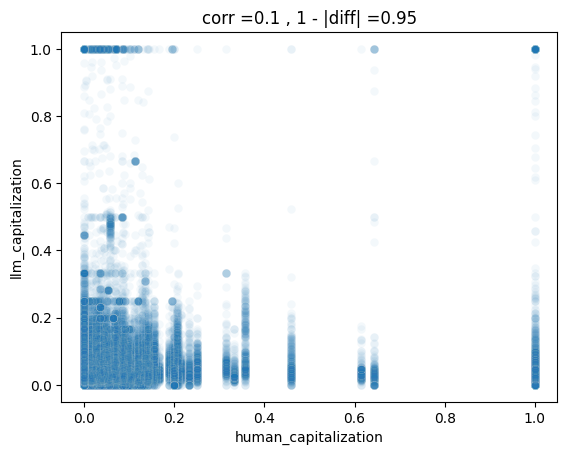

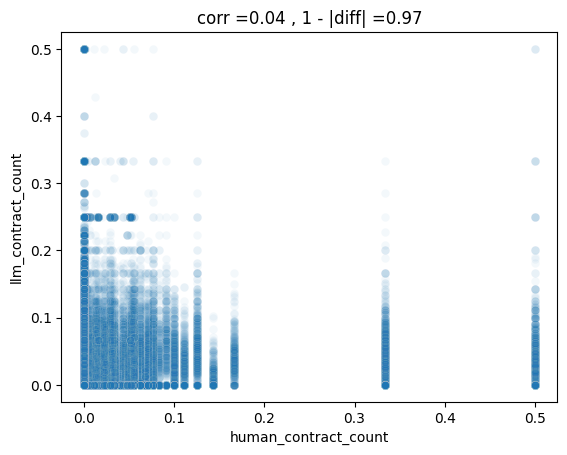

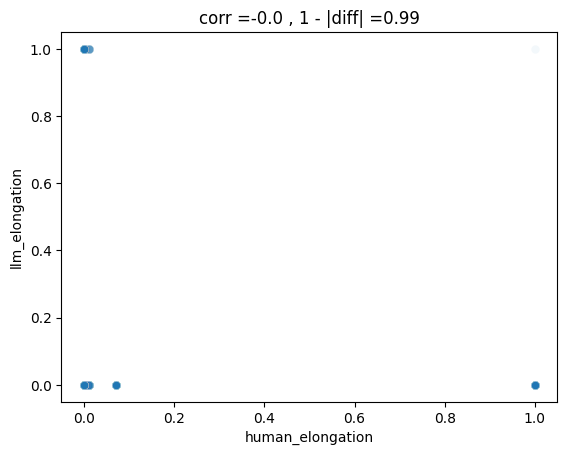

In [257]:
mod = 'Mistral-7B-Instruct-v0.3'
for c in [re.sub('metric_','',x) for x in orthographic]:
    if 'human_'+c in metrics.columns:
        if type(metrics['human_'+c][0])!=dict and type(metrics['human_'+c][0])!=list:
            sns.scatterplot(data = metrics, x = 'human_'+re.sub('metric_','',c), y = 'llm_'+re.sub('metric_','',c), alpha = 0.05)
            plt.title('corr =' + str(round(np.mean(plot_df[(plot_df.metric==c)]['corr']),2)) + 
                      ' , 1 - |diff| =' + str(round(np.mean(plot_df2[(plot_df2.metric==c)]['corr']),2)))
            plt.show()

In [260]:
plot_df[plot_df.category=='style'].groupby('metric')['corr'].mean()

metric
factuality      0.928475
formality       0.006636
luar            0.736965
politeness      0.133146
readability     0.201250
sentiment       0.170180
subjectivity    0.062160
toxicity        0.146600
Name: corr, dtype: float64

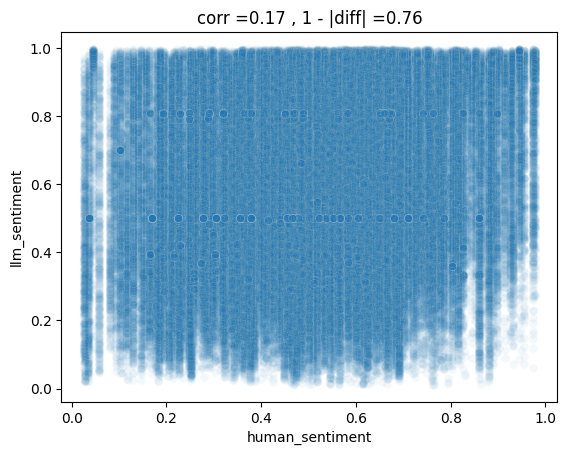

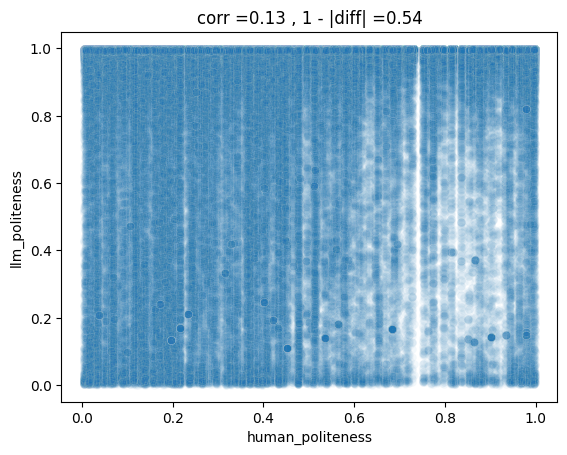

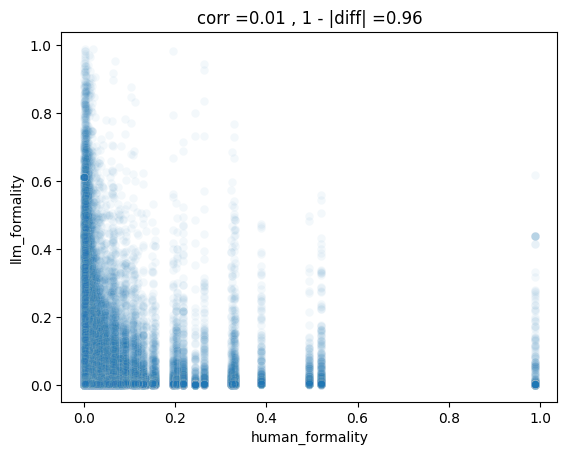

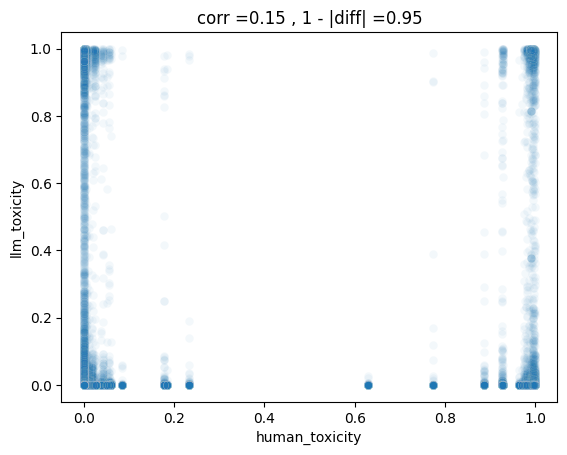

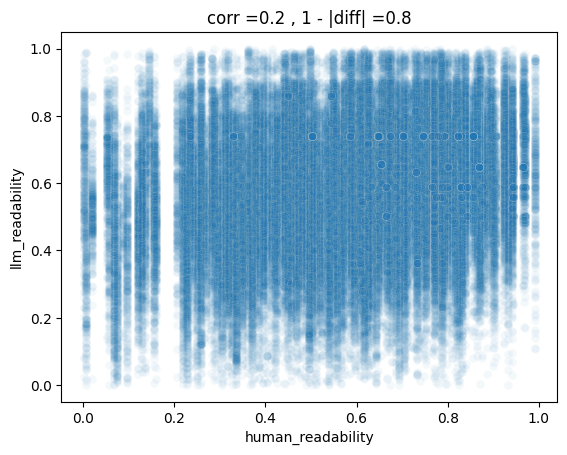

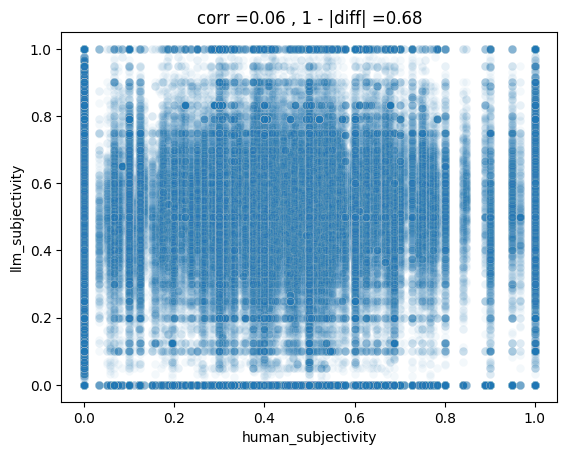

In [258]:
mod = 'Mistral-7B-Instruct-v0.3'
for c in [re.sub('metric_','',x) for x in style]:
    if 'human_'+c in metrics.columns:
        if type(metrics['human_'+c][0])!=dict and type(metrics['human_'+c][0])!=list:
            sns.scatterplot(data = metrics, x = 'human_'+re.sub('metric_','',c), y = 'llm_'+re.sub('metric_','',c), alpha = 0.05)
            plt.title('corr =' + str(round(np.mean(plot_df[(plot_df.metric==c)]['corr']),2)) + 
                      ' , 1 - |diff| =' + str(round(np.mean(plot_df2[(plot_df2.metric==c)]['corr']),2)))
            plt.show()

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


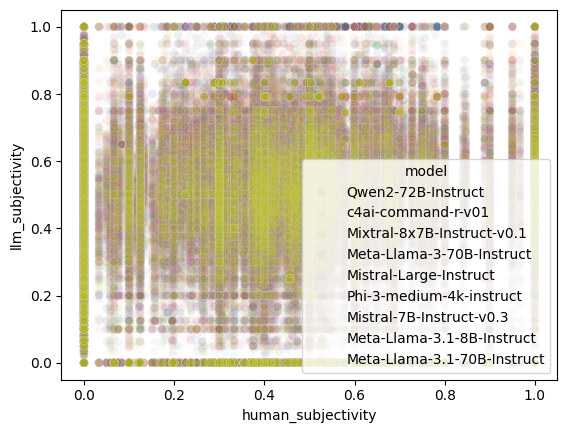

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


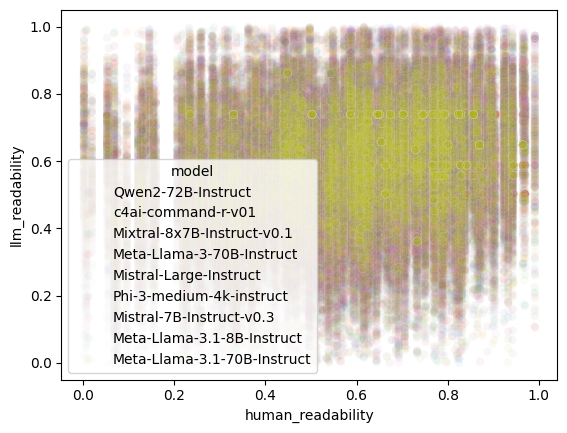

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


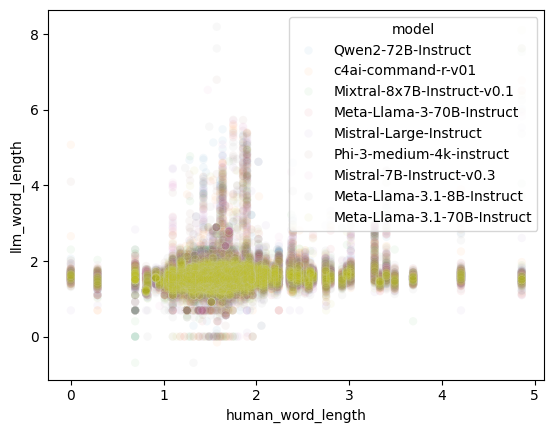

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


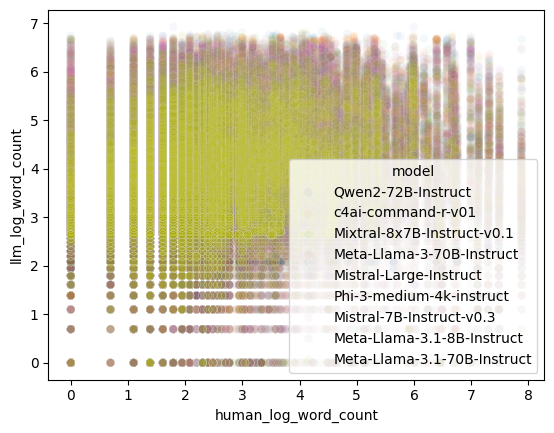

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


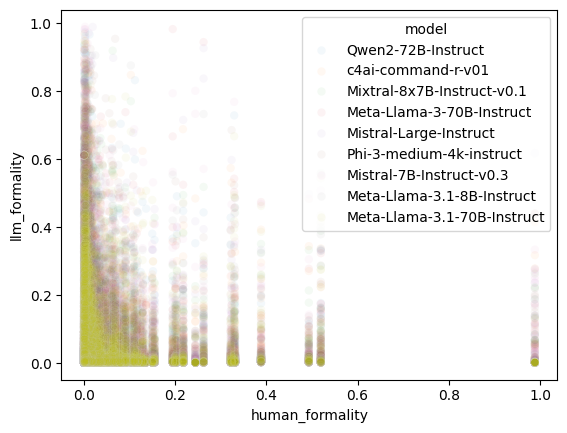

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


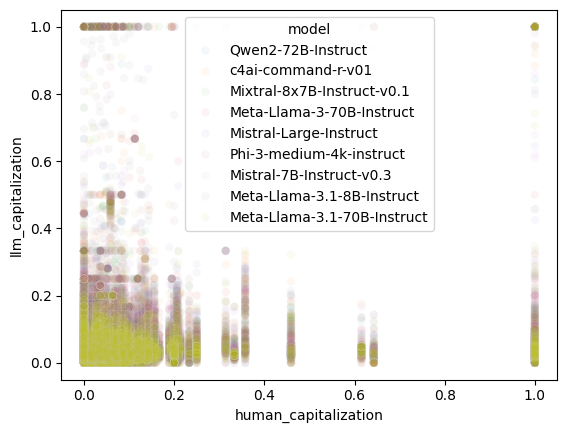

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


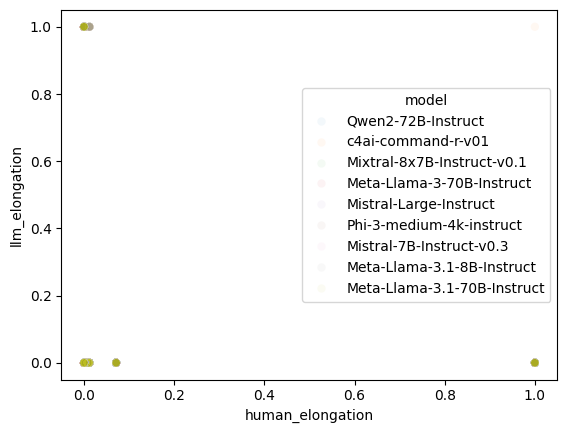

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


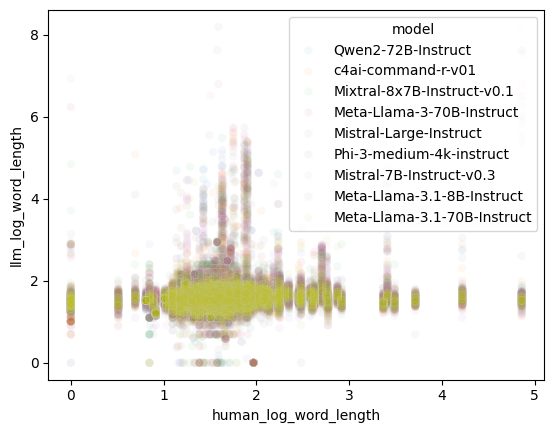

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


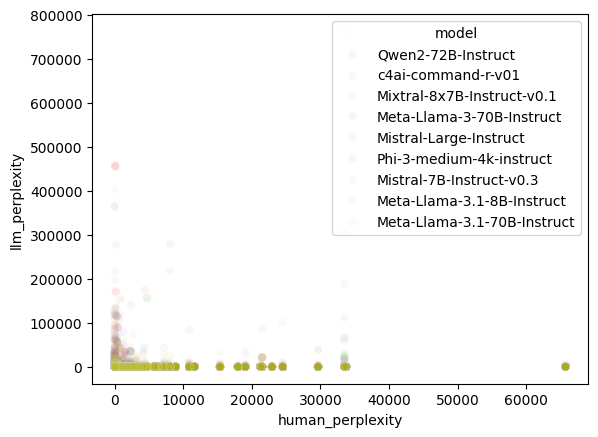

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


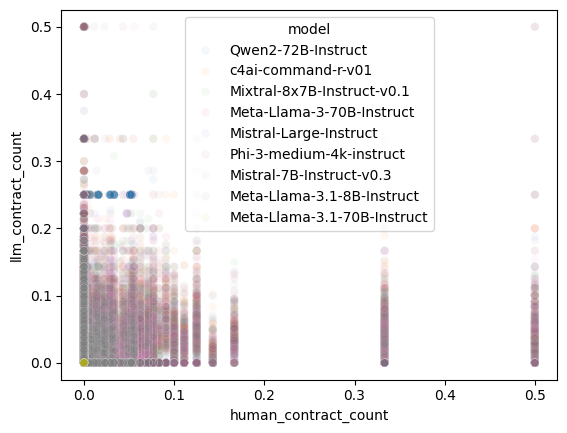

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


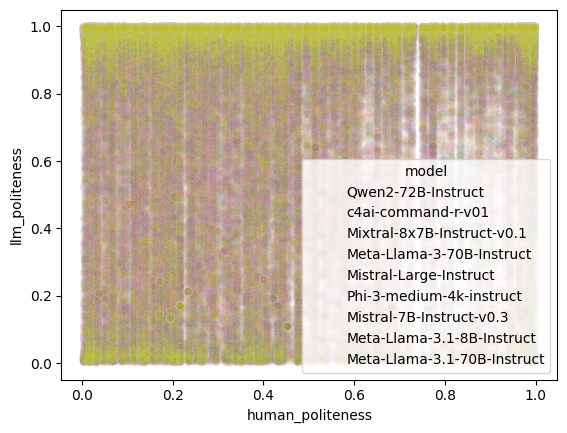

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


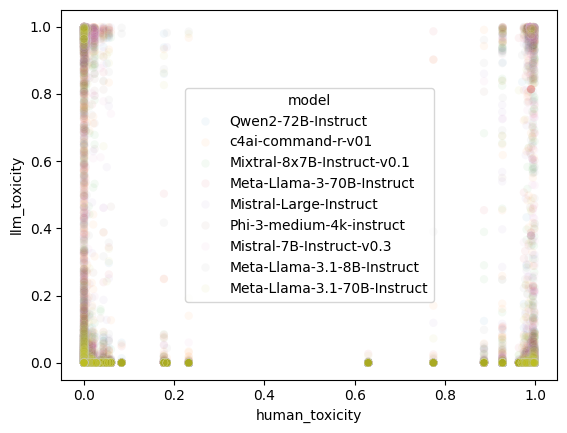

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


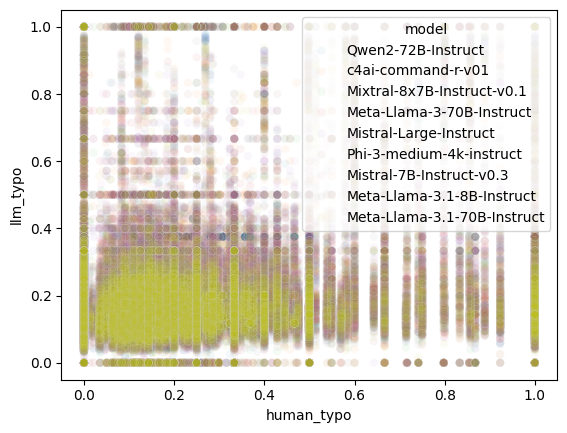

/opt/anaconda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


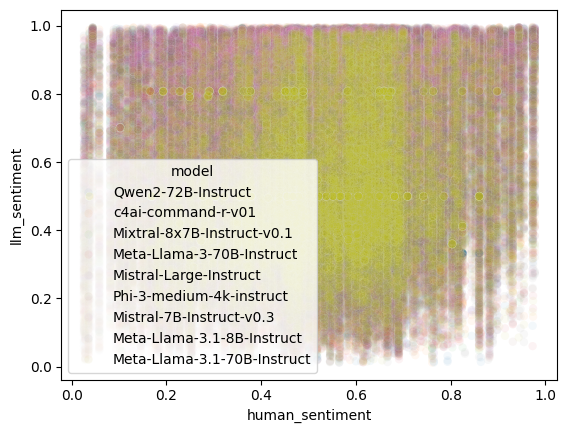

In [169]:
for c in set(plot_df.metric):
    if 'human_'+c in metrics.columns:
        if type(metrics['human_'+c][0])!=dict and type(metrics['human_'+c][0])!=list:
            sns.scatterplot(data = metrics, x = 'human_'+c, y = 'llm_'+c, hue = 'model', alpha = 0.05)
            plt.show()

In [76]:
datasets = {m: [] for m in set(metrics.model)}
errors = {m: [] for m in set(metrics.model)}
categories = ['lexical','orthographic','syntactic','semantic','style']

for m in set(metrics.model):
    cond = metrics.model==m
    for c in categories:
        datasets[m].append(np.mean(metrics['agg_'+c][cond]))
        boot = [np.mean(np.random.choice(metrics['agg_'+c][cond].tolist(), 
                                         sum(cond), replace=True)) for _ in range(10)]
        lo = np.percentile(boot, 0.025)
        hi = np.percentile(boot, 0.975)
        errors[m].append((hi - lo)/2)

In [90]:
radar_plot_data = {'categories':categories,
                   'datasets':datasets,
                   'errors':errors}

In [96]:
import json
with open("data/exp_1_radar_plot_data_models.json", "w") as outfile:
    json.dump(radar_plot_data,outfile)

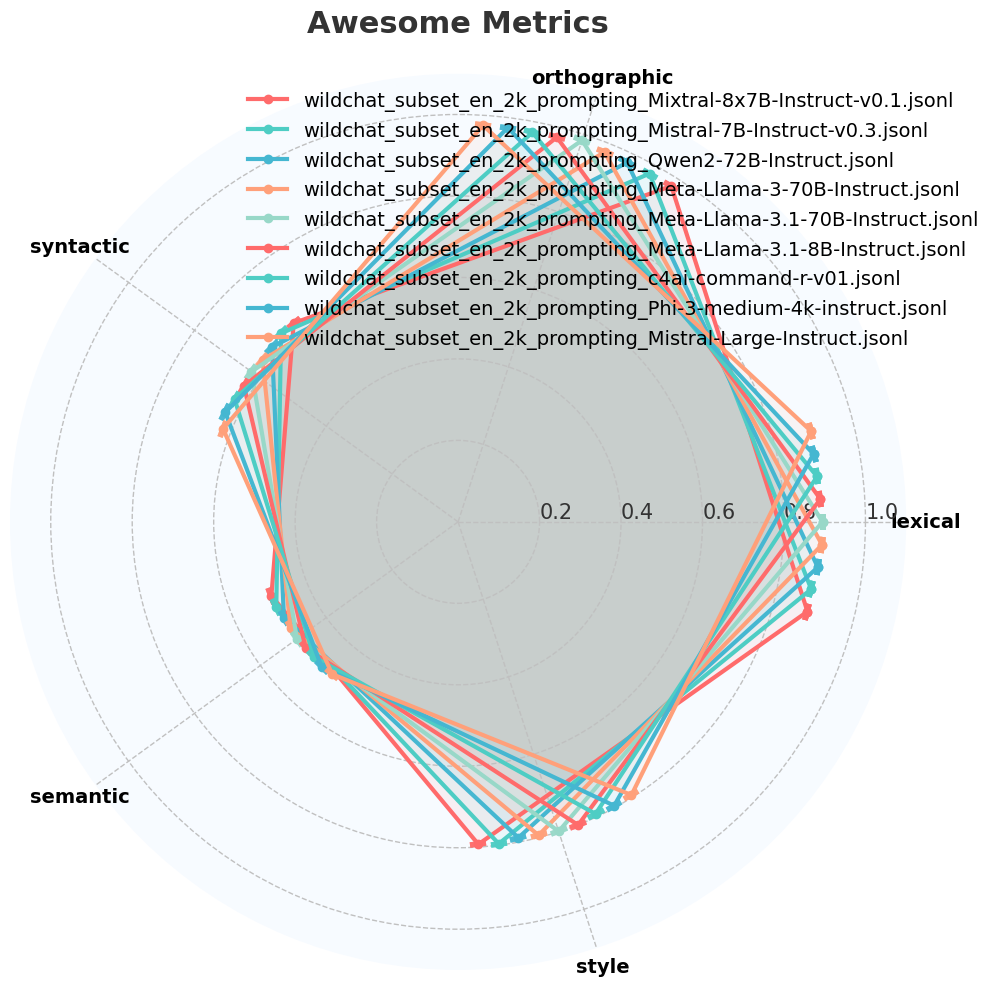

In [87]:
fig, ax = radar_plot(categories, datasets, errors)
plt.show()

In [102]:
cot_prompts = [5,9,10,12,17,19,25,26,28,30,31,33,46]
weird_prompts = [28,33,35,37,38,40,41,42,43,45,47,50]
override_prompts = [11,22,29,48,49]
override_prompts.extend(weird_prompts)
human_prompts = [i for i in range(1,51) 
                 if i not in cot_prompts and i not in weird_prompts and i not in override_prompts]
metrics['prompt_type'] = metrics.prompt.apply(lambda x: 'COT' if int(x[7:]) in cot_prompts
                                                else 'Override' if int(x[7:]) in override_prompts
                                                else 'Human' if int(x[7:]) in human_prompts
                                                else 'Other'
                                                )

In [105]:
var = 'prompt_type'
datasets = {m: [] for m in set(metrics[var])}
errors = {m: [] for m in set(metrics[var])}
categories = ['lexical','orthographic','syntactic','semantic','style']

for m in set(metrics[var]):
    cond = metrics[var]==m
    for c in categories:
        datasets[m].append(np.mean(metrics['agg_'+c][cond]))
        boot = [np.mean(np.random.choice(metrics['agg_'+c][cond].tolist(), 
                                         sum(cond), replace=True)) for _ in range(10)]
        lo = np.percentile(boot, 0.025)
        hi = np.percentile(boot, 0.975)
        errors[m].append((hi - lo)/2)

In [107]:
datasets

{'Human': [0.8933762823312466,
  0.9763723588746993,
  0.6261146243280429,
  0.4883144293994356,
  0.7938313152565882,
  0.8933762823312466],
 'COT': [0.8964648714607442,
  0.9790405639658613,
  0.625959240441461,
  0.48563142102331147,
  0.7940016024641434,
  0.8964648714607442],
 'Override': [0.8800436337307592,
  0.974156721540659,
  0.6300623502324907,
  0.49085370617963847,
  0.7975781467820845,
  0.8800436337307592]}

In [109]:
metrics.groupby('prompt_type')['agg_lexical'].mean()

prompt_type
COT         0.896465
Human       0.893376
Override    0.880044
Name: agg_lexical, dtype: float64

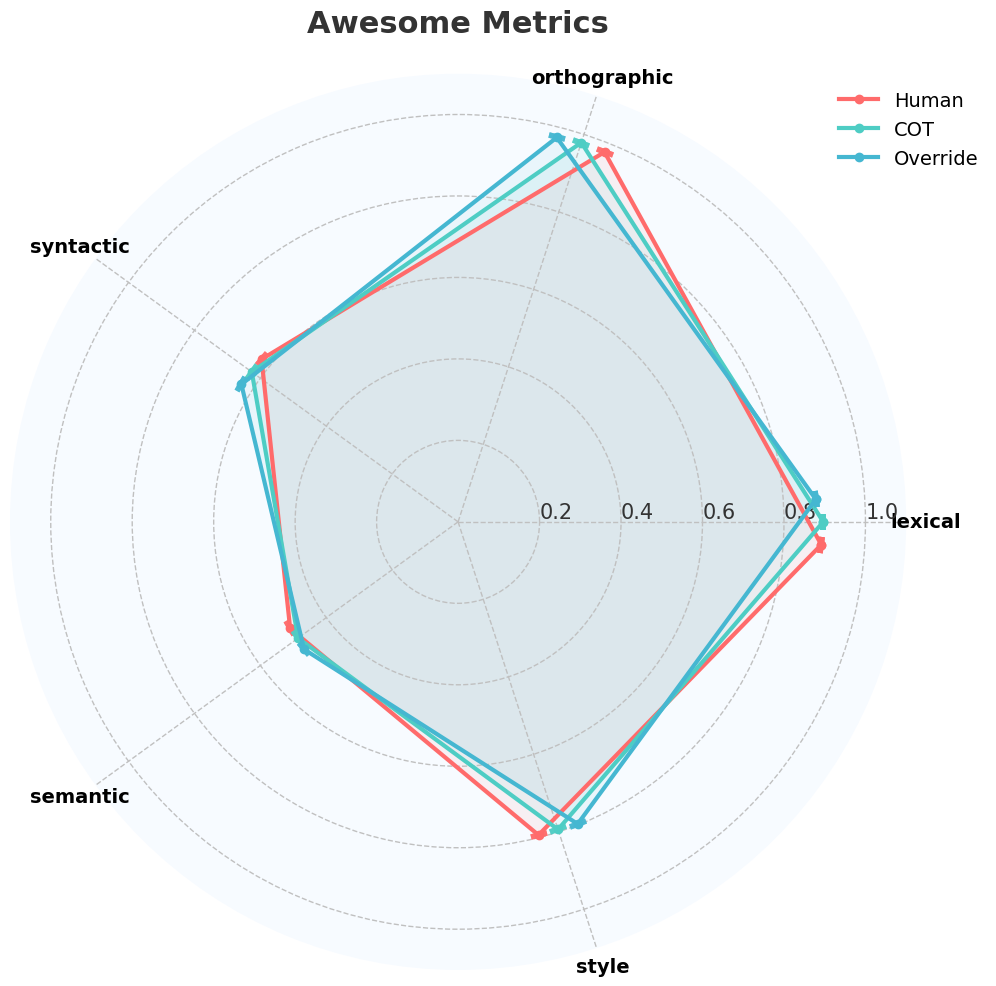

In [106]:
fig, ax = radar_plot(categories, datasets, errors)
plt.show()